In [19]:
import os 
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

dir_ = '../../../../../data/'
group_dir_ = '../../../../../data/groups/high'

In [2]:
file_name = 'normalized_to_rating_filter_track_5_user_100.csv'
df = pd.read_pickle(os.path.join(dir_, file_name[:-3] + 'pkl'))
svd = pd.read_pickle(os.path.join(dir_, 'prediction_svd_top_N_' + file_name[:-3] + 'pkl'))
train = np.loadtxt(os.path.join(dir_, 'rating_matrix_normalized_to_rating_filter_track_5_user_100.csv'), delimiter=',')
test = pd.read_pickle(os.path.join(dir_, 'test_' + file_name[:-3] + 'pkl'))
test.sort_values(by=['uid','tid'])

num_user = len(train)
num_track = len(train[0])
num_user, num_track

(953, 157567)

In [3]:
groups_n =[]
group_sizes = ['2', '3', '4', '5', '6', '7', '8']
for i in range(len(group_sizes)):
    groups = np.loadtxt(os.path.join(group_dir_, group_sizes[i] + '.csv'), delimiter=',')
    groups_n.append(groups)

In [4]:
def pearson_correlation(u1_index, u2_index):
        result = 0.0
        user1_data = train[u1_index]
        user2_data = train[u2_index]

        rx_avg = user_average_rating(user1_data)
        ry_avg = user_average_rating(user2_data)
        sxy = common_items(user1_data, user2_data)

        top_result = 0.0
        bottom_left_result = 0.0
        bottom_right_result = 0.0
        for item in sxy:
            rxs = user1_data[item]
            rys = user2_data[item]

            top_result += (rxs - rx_avg)*(rys - ry_avg)
            bottom_left_result += pow((rxs - rx_avg), 2)
            bottom_right_result += pow((rys - ry_avg), 2)
        bottom_left_result = math.sqrt(bottom_left_result)
        bottom_right_result = math.sqrt(bottom_right_result)
        
        ################################################################
        if (bottom_left_result * bottom_right_result) == 0:
            return -2, -2 # dump the data
        ################################################################
        
        result = top_result/(bottom_left_result * bottom_right_result)
        return len(sxy), result

def user_average_rating(u):
    avg_rating = 0.0
    for i in u:
        avg_rating += i
    avg_rating /= len(u) * 1.0
    return avg_rating

def common_items(u1, u2):
    result = []
    for i in range(num_track):
        if u1[i] > 0 and u2[i] > 0:
            result.append(i)
    return result

In [5]:
similarities = []
for groups in tqdm(groups_n):
    for gid in range(len(groups)):
        similarity = []
        group = groups[gid]
        for i in range(len(group)):
            for j in range(i+1, len(group)):
                u1 = int(group[i])
                u2 = int(group[j])
                c, p = pearson_correlation(u1, u2)
                p = p * min(c,200) / 200
                similarity.append(p)
        similarities.append([len(group), gid, sum(similarity)/len(similarity)])

  0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
pd_similarity = pd.DataFrame(similarities, columns=['group_size', 'gid', 'similarity'])
pd_similarity

,group_size,gid,similarity
0,2,0,0.581594
1,2,1,0.564442
2,2,2,0.591257
3,2,3,0.557180
4,2,4,0.552947
...,...,...,...
1098,8,48,0.671589
1099,8,49,0.662344
1100,8,50,0.624626
1101,8,51,0.618815


In [7]:
s = pd_similarity[pd_similarity['group_size']==8]['similarity']
sum(s)/len(s)

0.6632880153318012

In [8]:
pd_similarity.to_pickle("similarity_h.pkl")
pd_similarity = pd.read_pickle("similarity_h.pkl")

In [9]:
pd_similarity

,group_size,gid,similarity
0,2,0,0.581594
1,2,1,0.564442
2,2,2,0.591257
3,2,3,0.557180
4,2,4,0.552947
...,...,...,...
1098,8,48,0.671589
1099,8,49,0.662344
1100,8,50,0.624626
1101,8,51,0.618815


In [10]:
pd_similarity[(pd_similarity['group_size']==2) & (pd_similarity['gid']==0)]['similarity'].values[0]

0.5815939176890574

In [11]:
top_n = './50'
g_type = 'h'
p = pd.read_pickle(os.path.join(top_n, g_type + '_p.pkl'))
r = pd.read_pickle(os.path.join(top_n, g_type + '_r.pkl'))
n = pd.read_pickle(os.path.join(top_n, g_type + '_n.pkl'))

In [12]:
# Choose lambda
opt_lambdas = []
for g_size in range(2,9):
    target_groups = p[p['group_size']==g_size]
    for gid in target_groups['gid'].unique():
        target_group = target_groups[target_groups['gid']==gid]
        p_lambdas = []
        for lambda_ in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            p_lambda = target_group[target_group['lambda']==lambda_]
            p_lambdas.append(sum(p_lambda['values'].values)/len(p_lambda['values'].values))
        opt_lambda = p_lambdas.index(max(p_lambdas))/10
        similarity = pd_similarity[(pd_similarity['group_size']==g_size) & (pd_similarity['gid']==gid)]['similarity'].values[0]
        opt_lambdas.append([g_size, gid, similarity, opt_lambda])

In [13]:
pd_opt_lambda = pd.DataFrame(opt_lambdas, columns=['group_size', 'gid', 'similarity', 'opt_lambda'])
pd_opt_lambda

,group_size,gid,similarity,opt_lambda
0,2,0,0.581594,0.3
1,2,1,0.564442,0.6
2,2,2,0.591257,0.6
3,2,3,0.557180,0.8
4,2,4,0.552947,0.6
...,...,...,...,...
1098,8,48,0.671589,0.4
1099,8,49,0.662344,0.1
1100,8,50,0.624626,0.3
1101,8,51,0.618815,0.3


In [14]:
lambda_list = []
# Evaluation
precision_list = []
recall_list = []
nDCG_list = []
for round_ in range(5):
    precisions = []
    recalls = []
    nDCGs = []
    # Training the regression model for choosing optimal lambda
    for g_size in range(2,9):
        pd_opt_lambda_g = pd_opt_lambda[pd_opt_lambda['group_size']==g_size]
        num_group = len(pd_opt_lambda_g)
        train = pd_opt_lambda_g[(pd_opt_lambda_g['gid']<int(num_group/5*round_)) | (pd_opt_lambda_g['gid']>=int(num_group/5*(round_+1)))]

        X_train = train['similarity'].values
        y_train = train['opt_lambda'].values
        X_train = X_train[:, np.newaxis]
        
        lm = LinearRegression()
        lm.fit(X_train, y_train)
        
        test_p = p[p['group_size']==g_size]
        test_r = r[r['group_size']==g_size]
        test_n = n[n['group_size']==g_size]
        
        test_p = test_p[(test_p['gid']>=int(num_group/5*round_)) & (test_p['gid']<int(num_group/5*(round_+1)))]
        test_r = test_r[(test_r['gid']>=int(num_group/5*round_)) & (test_r['gid']<int(num_group/5*(round_+1)))]
        test_n = test_n[(test_n['gid']>=int(num_group/5*round_)) & (test_n['gid']<int(num_group/5*(round_+1)))]
        
        precision = []
        recall = []
        nDCG = []
        for gid in test_p['gid'].unique():
            gt = pd_opt_lambda[(pd_opt_lambda['group_size']==g_size) & (pd_opt_lambda['gid']==gid)]['opt_lambda'].values[0]
            similarity = pd_similarity[(pd_similarity['group_size']==g_size) & (pd_similarity['gid']==gid)]['similarity'].values[0]
            opt_lambda = np.round(lm.predict([[similarity]])[0], 1)
            lambda_list.append([g_size, gid, opt_lambda])
            
            precision.append(test_p[(test_p['gid']==gid) & (test_p['lambda']==opt_lambda)]['values'].values[0])
            recall.append(test_r[(test_r['gid']==gid) & (test_r['lambda']==opt_lambda)]['values'].values[0])
            nDCG.append(test_n[(test_n['gid']==gid) & (test_n['lambda']==opt_lambda)]['values'].values[0])
        precisions.append(sum(precision)/len(precision))
        recalls.append(sum(recall)/len(recall))
        nDCGs.append(sum(nDCG)/len(nDCG))
    precision_list.append(precisions)
    recall_list.append(recalls)
    nDCG_list.append(nDCGs)

In [18]:
chosen_lambda = pd.DataFrame(lambda_list, columns=['group_size', 'gid', 'opt_lambda'])
for g_size in range(2,9):
    chosen_lambda_g = chosen_lambda[chosen_lambda['group_size']==g_size]
    print(chosen_lambda_g)
    print(sum(chosen_lambda_g['opt_lambda'])/len(chosen_lambda_g['opt_lambda']))

     group_size  gid  opt_lambda
0             2    0         0.5
1             2    1         0.5
2             2    2         0.5
3             2    3         0.5
4             2    4         0.5
..          ...  ...         ...
956           2  402         0.4
957           2  403         0.4
958           2  404         0.4
959           2  405         0.5
960           2  406         0.4

[407 rows x 3 columns]
0.513513513513513
      group_size  gid  opt_lambda
81             3    0         0.4
82             3    1         0.4
83             3    2         0.4
84             3    3         0.4
85             3    4         0.4
...          ...  ...         ...
1004           3  232         0.5
1005           3  233         0.5
1006           3  234         0.5
1007           3  235         0.5
1008           3  236         0.5

[237 rows x 3 columns]
0.48185654008438805
      group_size  gid  opt_lambda
128            4    0         0.4
129            4    1         0.4
130     

In [16]:
p_avg = []
r_avg = []
n_avg = []
for g_size in range(7):
    precision = 0
    recall = 0
    nDCG = 0
    for round_ in range(5):
        precision += precision_list[round_][g_size]
        recall += recall_list[round_][g_size]
        nDCG += nDCG_list[round_][g_size]
    p_avg.append(precision/5)
    r_avg.append(recall/5)
    n_avg.append(nDCG/5)

In [17]:
print(sum(p_avg)/len(p_avg))
print(sum(r_avg)/len(r_avg))
print(sum(n_avg)/len(n_avg))

0.14646469886107752
0.009363523035220062
0.07659649449582252


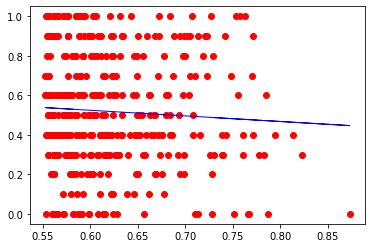

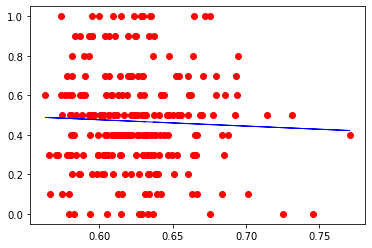

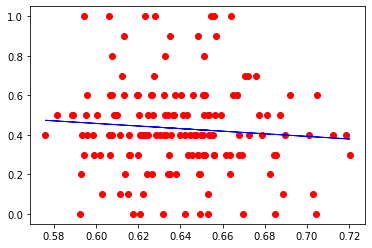

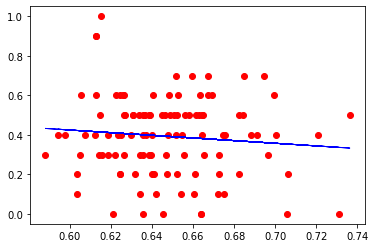

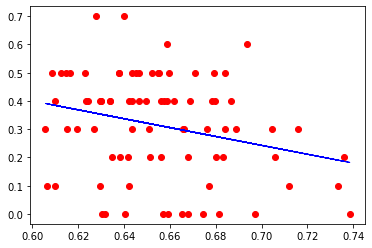

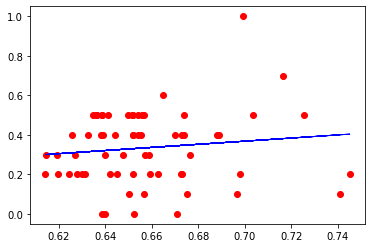

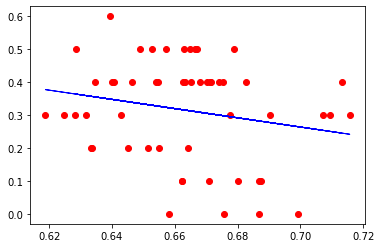

In [20]:
for g_size in range(2,9):
    train = pd_opt_lambda[pd_opt_lambda['group_size']==g_size]
    X_train = train['similarity'].values
    y_train = train['opt_lambda'].values
    X_train = X_train[:, np.newaxis]

    lm = LinearRegression()
    lm.fit(X_train, y_train)
    
    plt.scatter(X_train, y_train, color='red')
    plt.plot(X_train, lm.predict(X_train),color='blue',linewidth=1)
    plt.show()